In [1]:
!pip install pandas seaborn scikit-learn

# Домашнее задание по практике 2

*   Новый пункт
*   Новый пункт



- Провести разведочный анализ EDA (описать полученный результат). Тут важно, влияет ли X[i] на Y (примеры в практике 2)
- Описать полученный результат относительно анализа целевой перменной и зависимой (см. практика 2)
- Подобороться с пропусками в данных (при наличии в датасете). Объяснить способ выборка борьбы с пропуском
- Обучить модель линейной регресии на всей выборке X, y. Вывести метрики
- Сделать train_test_split и обучить на обучающей выборке. Предсказать результат на обучающей и тестовой выборках. Вывести метрики, объяснить полученный результат

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('student_performance.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB


In [5]:
# преобразовать категориальные признаки в category
df['grade'] = df['grade'].astype('category')

In [6]:
# выбрать целевую переменную и разделить на X, y
# целевая переменная - числовой непрерывный признак

y = df.total_score
X = df.drop('total_score', axis=1)
X.head(n=3)

,student_id,weekly_self_study_hours,attendance_percentage,class_participation,grade
0,1,18.5,95.6,3.8,A
1,2,14.0,80.0,2.5,B
2,3,19.5,86.3,5.3,A


In [7]:
y.head(n=3)

,total_score
0,97.9
1,83.9
2,100.0


## EDA (разведочный анализ относительно целевой переменной)

в этом же блоке побороться с проусками, важно сделать именно после разведочного анализа
- Y и категориальные
- Y и числовые
- Описать все полученные результаты в своем блоке

- Отобрать признаки для дальнейшего анализа, записать в ```best_features```

            mean       std   count
grade                             
A      96.042375  4.930847  548644
B      77.946590  4.272258  258174
C      63.564524  4.216840  141980
D      49.380346  4.007757   44998
F      35.474146  4.050442    6204


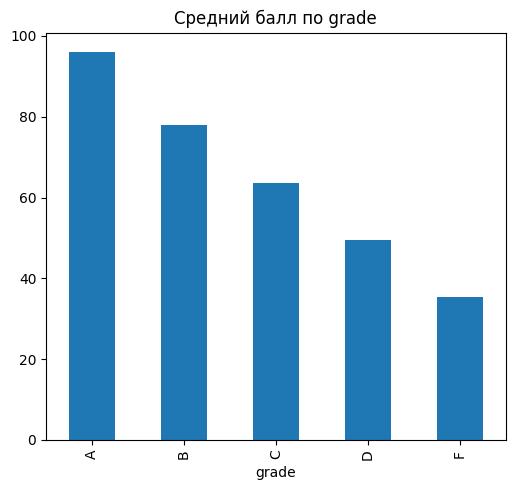

                          mean        std  count
class_participation                             
0.0                  84.332042  15.382912   1420
0.1                  84.339462  14.713295    223
0.2                  84.038487  15.676652    304
0.3                  83.187500  15.800129    336
0.4                  84.420398  15.107321    402
...                        ...        ...    ...
9.6                  84.243809  15.574433   4038
9.7                  84.341348  15.597724   3635
9.8                  84.252101  15.769449   3332
9.9                  84.192769  15.450174   3015
10.0                 84.363026  15.408166  24128

[101 rows x 3 columns]


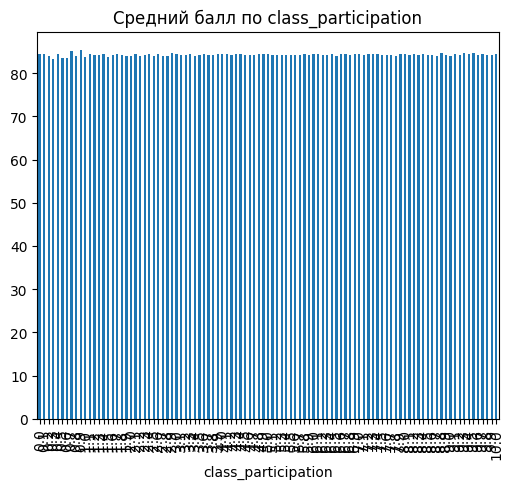

In [8]:
#влияние категориальных переменных на y
import matplotlib.pyplot as plt

cat_columns = ['grade', 'class_participation']

for cat_col in cat_columns:
    group_stats = df.groupby(cat_col, observed=True)['total_score'].agg(['mean', 'std', 'count'])
    print(group_stats)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 2)
    df.groupby(cat_col, observed=True)['total_score'].mean().plot(kind='bar')
    plt.title(f'Средний балл по {cat_col}')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

Grade - является важным элементом итогового балла. Чем выше оценка, тем выше итоговый балл. Четкая линейная зависимость.

Class_participation - не является значимым элементом итогового балла. Нет четкой зависимости.

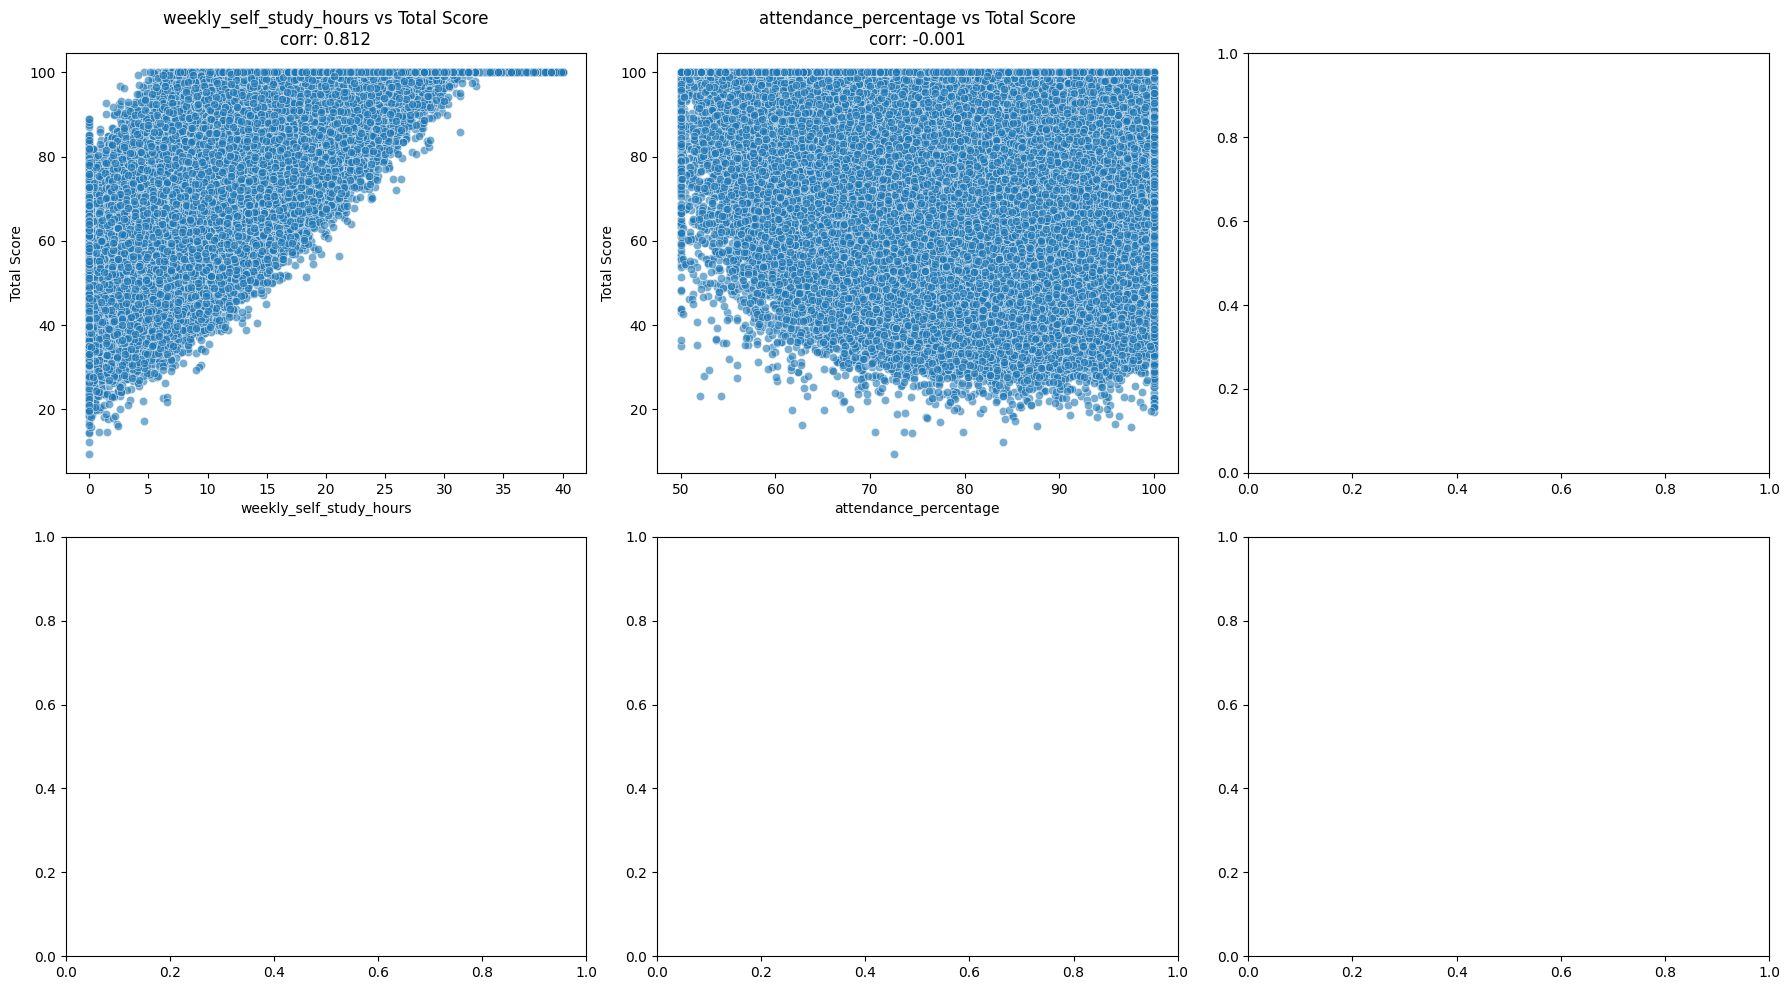

In [9]:
#влияние числовых переменных на y
import seaborn as sns
numerical_columns = ['weekly_self_study_hours', 'attendance_percentage']
correlations = df[numerical_columns].corrwith(y).sort_values(ascending=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(numerical_columns):
    sns.scatterplot(x=df[feature], y=df['total_score'], alpha=0.6, ax=axes[i])
    correlation = correlations[feature]
    axes[i].set_title(f'{feature} vs Total Score\ncorr: {correlation:.3f}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Total Score')

plt.tight_layout()
plt.show()

weekly_self_study_hours - сильная положительная зависимость.

attendance_percentage - слабая зависимость, практически ее нет.

In [10]:
miss_data = df.isnull().sum()
miss_data

,0
student_id,0
weekly_self_study_hours,0
attendance_percentage,0
class_participation,0
total_score,0
grade,0


Пустых значений в датасете нет

In [11]:
categorial_features = ['grade'] # перечислить названия колонок с категориальными фичами
numeric_features = ['weekly_self_study_hours'] # перечислить названия колонок с категориальными фичами
best_features = categorial_features + numeric_features

## Моделирование

**Общая задача:**
Сравнить несколько вариантов линейной регрессии на датасете (с предобработкой признаков: стандартизация числовых, OneHot/Label для категориальных).

**предобработка**
- Категориальные признаки преобразовать с помощью OneHotEncoder (если признак является типом **bool** по логике можно интерпретировать как (true, false) То можно LabelEncoder)
- Числовые признаки записать в `X_scaled` и провести стандартизацию с помощью `StandardScaler`. Желательно без категориальных признаков


---
**Метрики**: (MAE, MAPE, R², MSE, RMSE)

---

**Модель 1.**

- Использовать **все признаки (кроме y)**.
- Обучить на **всей выборке** (без разделения).
- Сделать предсказания на этой же выборке.
- Вывести метрики и интерпретировать.
- Построить график коэффициентов (model.coef\_ vs X\_scaled.columns) и интерпретировать.

---

**Модель 2.**

- Использовать **все признаки**.
- Сделать `train_test_split`.
- Обучить на `X_train`, предсказать на `X_train` и `X_test`.
- Вывести метрики для обучающей и тестовой выборки, интерпретировать.
- Визуализировать коэффициенты и интерпретировать.

---

**Модель 3.**

- Использовать только **best\_features** (отобранные признаки).
- Обучить на **всей выборке**.
- Предсказать на всей выборке.
- Вывести метрики качества и интерпретировать.
- Визуализировать коэффициенты и интерпретировать.

---

**Модель 4.**

- Использовать **best\_features**.
- Сделать `train_test_split`.
- Обучить на `X_train`, предсказать на `X_train` и `X_test`.
- Вывести метрики качества для обучающей и тестовой выборки, интерпретировать.
- Визуализировать коэффициенты и интерпретировать.

---

P.S.
- Важно не забывать о стандартизации и разделении категориальных признаков на отдельные олонки
- Все примеры есть в практике 2


P.S.S
Старайтесь делать собственные предположения, ChatGPT задачу решит, но вы не добьетесь понимания полученных результатов

---
В результате должно получиться 4 модели

- первые две на всех колонках (фичах)
- последующие на отобранных фичах (колонках)

### **предобработка**

In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(X[['grade']])
X_encoded = encoded

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['weekly_self_study_hours', 'attendance_percentage', 'class_participation']])

In [14]:
import numpy as np
X_all_n = np.hstack([X_encoded, X_scaled])

In [15]:
X_all = pd.DataFrame(X_all_n)
X_all.head()

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.503067,1.155432,-1.116940
1,0.0,1.0,0.0,0.0,0.0,-0.149161,-0.499891,-1.781419
2,1.0,0.0,0.0,0.0,0.0,0.648006,0.168605,-0.350233
3,1.0,0.0,0.0,0.0,0.0,1.546632,-1.539774,0.518701
4,1.0,0.0,0.0,0.0,0.0,-0.236125,-0.298281,0.467588


In [16]:
grade_columns = [f'grade_{cat}' for cat in encoder.categories_[0]]
numeric_columns = ['weekly_self_study_hours', 'attendance_percentage', 'class_participation']
all_columns = grade_columns + numeric_columns
X_all = pd.DataFrame(X_all_n, columns=all_columns)
X_all.head()

,grade_A,grade_B,grade_C,grade_D,grade_F,weekly_self_study_hours,attendance_percentage,class_participation
0,1.0,0.0,0.0,0.0,0.0,0.503067,1.155432,-1.116940
1,0.0,1.0,0.0,0.0,0.0,-0.149161,-0.499891,-1.781419
2,1.0,0.0,0.0,0.0,0.0,0.648006,0.168605,-0.350233
3,1.0,0.0,0.0,0.0,0.0,1.546632,-1.539774,0.518701
4,1.0,0.0,0.0,0.0,0.0,-0.236125,-0.298281,0.467588


In [17]:
columns_drop = ['attendance_percentage', 'class_participation']
X_best = X_all.drop(columns=columns_drop)
X_best.head()

,grade_A,grade_B,grade_C,grade_D,grade_F,weekly_self_study_hours
0,1.0,0.0,0.0,0.0,0.0,0.503067
1,0.0,1.0,0.0,0.0,0.0,-0.149161
2,1.0,0.0,0.0,0.0,0.0,0.648006
3,1.0,0.0,0.0,0.0,0.0,1.546632
4,1.0,0.0,0.0,0.0,0.0,-0.236125


### **Модель 1**

In [18]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False,
)

In [19]:
model1.fit(X_all, y)

LinearRegression()

In [20]:
y_pred = model1.predict(X_all)
y_pred

array([95.60679951, 78.89911111, 96.10596765, ..., 93.44708053,
       99.01439517, 95.50673843])

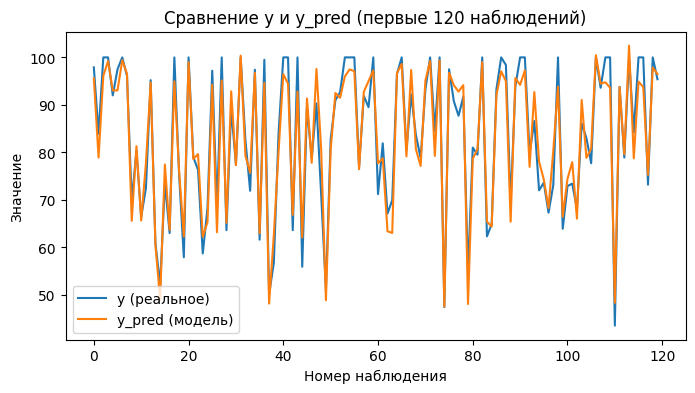

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

n = 120
y_small = y[:n]
y_pred_small = y_pred[:n]

plt.figure(figsize=(8, 4))
sns.lineplot(x=range(len(y_small)), y=y_small, label="y (реальное)")
sns.lineplot(x=range(len(y_pred_small)), y=y_pred_small, label="y_pred (модель)")

plt.xlabel("Номер наблюдения")
plt.ylabel("Значение")
plt.title(f"Сравнение y и y_pred (первые {n} наблюдений)")
plt.legend()
plt.show()

В целом модель повторяет динамику реальных данных, однако занижает экстремальные значения и сглаживает пики.

In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error, root_mean_squared_error

MAE = mean_absolute_error(y, y_pred)
print('MAE %.3f' % MAE)

MAPE = mean_absolute_percentage_error(y, y_pred)
print('MAPE=%.3f, MAPE_as_percent=%.3f%s' % (MAPE, MAPE * 100, '%'))

R2 = r2_score(y, y_pred)
print('R2=%.3f' % R2)

MSE = mean_squared_error(y, y_pred)
print('MSE=%.3f' % MSE)

RMSE = root_mean_squared_error(y, y_pred)
print('RMSE=%.3f' % RMSE)

MAE 3.337
MAPE=0.042, MAPE_as_percent=4.186%
R2=0.932
MSE=16.230
RMSE=4.029


**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка состовляет 3,34%, что является хорошим результатом, но стоит стремиться к нулю.

**MAPE (Mean Absolute Percentage Error)**

Средняя процентная ошибка состовляет 4,19%, считается отличным результатом(<10%).

**R² (Коэффициент детерминации)**

Коэффициент детерминации модели равен 0,93 - отличный результат, так как он приближен к единице.

**MSE (Mean Squared Error)**

Средний квадрат ошибок равен 16,23, что нельзя назвать плохим результатом, однако все же не хороший, так как значение далеко от нуля.

**RMSE (Root Mean Squared Error)**

Стандартное отклонине ошибок 4,03, лучше чем MSE, но следует так же стремиться к нулю.

In [23]:
model1.coef_

array([ 2.63042888e+01,  1.18495097e+01, -3.13738963e-01, -1.25284783e+01,
       -2.53115813e+01,  3.46007888e+00, -7.28171490e-04, -3.98163807e-03])

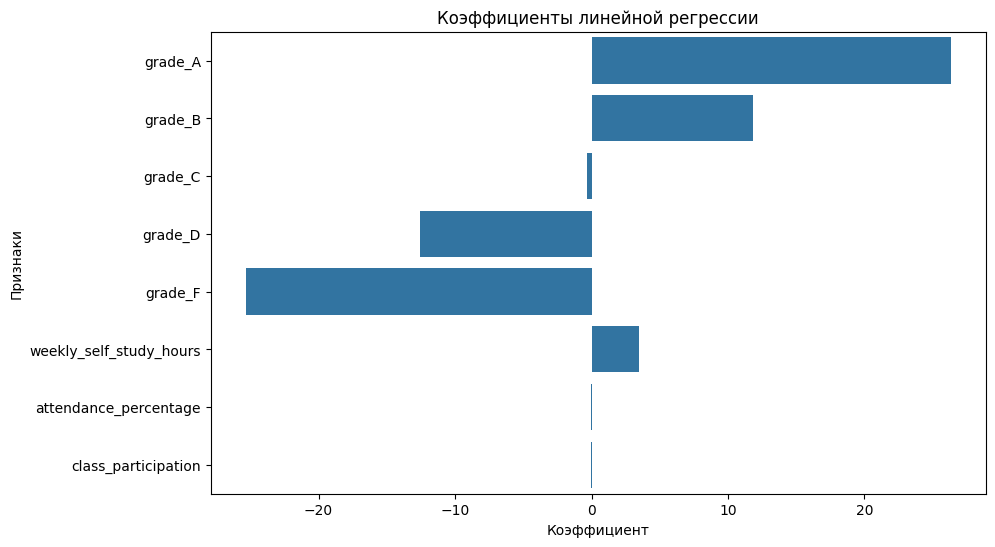

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(x=model1.coef_, y=X_all.columns, orient="h")
plt.xlabel("Коэффициент")
plt.ylabel("Признаки")
plt.title("Коэффициенты линейной регрессии")
plt.show()

Оценки A и B и часы саообучения влияют и повышают итоговый балл студентов.

Оценки D и F влияют на итоговый балл негативно, понижая его

Участие в классе, посещаемость и оценка С можно сказать не влияет на итоговый балл.

### **Модель 2**

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800000, 200000, 800000, 200000)

In [26]:
model2 = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False,
)

In [27]:
model2.fit(X_train, y_train)

LinearRegression()

In [28]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

In [29]:
def calculate_metrics(y_true, y_pred):

  MAE = mean_absolute_error(y_true, y_pred)
  print('MAE %.3f' % MAE)

  MAPE = mean_absolute_percentage_error(y_true, y_pred)
  print('MAPE=%.3f, MAPE_as_percent=%.3f%s' % (MAPE, MAPE * 100, '%'))

  R2 = r2_score(y_true, y_pred)
  print('R2=%.3f' % R2)

  MSE = mean_squared_error(y_true, y_pred)
  print('MSE=%.3f' % MSE)

  RMSE = root_mean_squared_error(y_true, y_pred)
  print('RMSE=%.3f' % RMSE)

In [30]:
print('метрики для выборки на которых обучалась модель')
calculate_metrics(y_train, y_train_pred)

метрики для выборки на которых обучалась модель
MAE 3.337
MAPE=0.042, MAPE_as_percent=4.185%
R2=0.932
MSE=16.230
RMSE=4.029


In [31]:
print('метрики для выборки на которых модель никогда не обучалась')
calculate_metrics(y_test, y_test_pred)

метрики для выборки на которых модель никогда не обучалась
MAE 3.339
MAPE=0.042, MAPE_as_percent=4.186%
R2=0.932
MSE=16.230
RMSE=4.029


Метрики на train и test выборках практически идентичны, меняются лишь сотые значения за запятой. Все значения хорошие.

In [32]:
model2.coef_

array([ 2.62852029e+01,  1.18390032e+01, -3.27838747e-01, -1.25391822e+01,
       -2.52571851e+01,  3.46454348e+00,  1.39274323e-03, -1.66494311e-03])

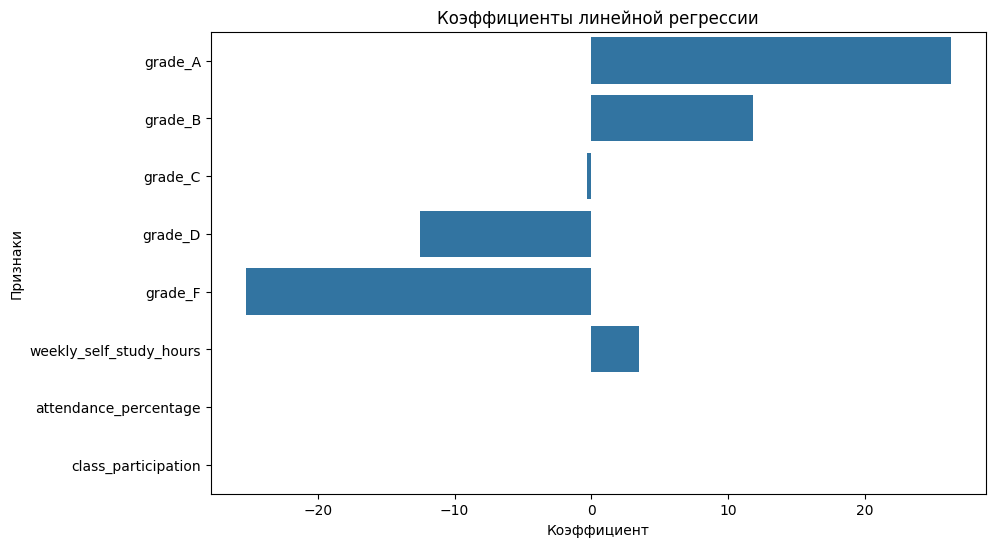

In [33]:
plt.figure(figsize=(10,6))
sns.barplot(x=model2.coef_, y=X_all.columns, orient="h")
plt.xlabel("Коэффициент")
plt.ylabel("Признаки")
plt.title("Коэффициенты линейной регрессии")
plt.show()

Ситуация идентична модели 1

Оценки A и B и часы саообучения влияют и повышают итоговый балл студентов.

Оценки D и F влияют на итоговый балл негативно, понижая его

Участие в классе, посещаемость и оценка С можно сказать не влияет на итоговый балл.

### **Модель 3**

In [34]:
model3 = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False,
)

In [35]:
model3.fit(X_best, y)

LinearRegression()

In [36]:
y_pred3 = model3.predict(X_best)
y_pred3

array([95.60319134, 78.89165303, 96.10469298, ..., 93.44673427,
       99.01340251, 95.50289101])

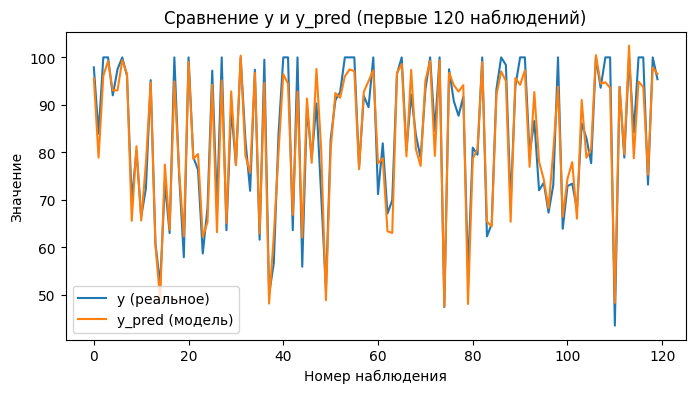

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

n = 120
y_small = y[:n]
y_pred_small = y_pred3[:n]

plt.figure(figsize=(8, 4))
sns.lineplot(x=range(len(y_small)), y=y_small, label="y (реальное)")
sns.lineplot(x=range(len(y_pred_small)), y=y_pred_small, label="y_pred (модель)")

plt.xlabel("Номер наблюдения")
plt.ylabel("Значение")
plt.title(f"Сравнение y и y_pred (первые {n} наблюдений)")
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error, root_mean_squared_error

MAE = mean_absolute_error(y, y_pred3)
print('MAE %.3f' % MAE)

MAPE = mean_absolute_percentage_error(y, y_pred3)
print('MAPE=%.3f, MAPE_as_percent=%.3f%s' % (MAPE, MAPE * 100, '%'))

R2 = r2_score(y, y_pred3)
print('R2=%.3f' % R2)

MSE = mean_squared_error(y, y_pred3)
print('MSE=%.3f' % MSE)

RMSE = root_mean_squared_error(y, y_pred3)
print('RMSE=%.3f' % RMSE)

MAE 3.337
MAPE=0.042, MAPE_as_percent=4.186%
R2=0.932
MSE=16.230
RMSE=4.029


In [39]:
model3.coef_

array([ 26.3042945 ,  11.84951359,  -0.31372265, -12.52849447,
       -25.31159097,   3.46007427])

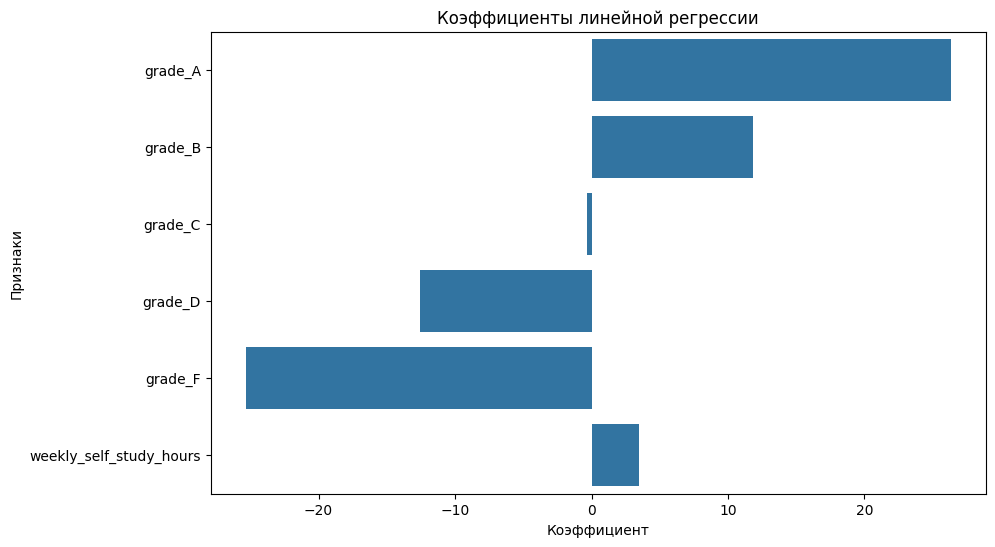

In [40]:
plt.figure(figsize=(10,6))
sns.barplot(x=model3.coef_, y=X_best.columns, orient="h")
plt.xlabel("Коэффициент")
plt.ylabel("Признаки")
plt.title("Коэффициенты линейной регрессии")
plt.show()

### **Модель 4**

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800000, 200000, 800000, 200000)

In [42]:
model4 = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False,
)

In [43]:
model4.fit(X_train, y_train)

LinearRegression()

In [44]:
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

In [45]:
print('метрики для выборки на которых обучалась модель')
calculate_metrics(y_train, y_train_pred)

метрики для выборки на которых обучалась модель
MAE 3.337
MAPE=0.042, MAPE_as_percent=4.185%
R2=0.932
MSE=16.230
RMSE=4.029


In [46]:
print('метрики для выборки на которых модель никогда не обучалась')
calculate_metrics(y_test, y_test_pred)

метрики для выборки на которых модель никогда не обучалась
MAE 3.339
MAPE=0.042, MAPE_as_percent=4.186%
R2=0.932
MSE=16.230
RMSE=4.029


In [47]:
model4.coef_

array([ 26.28520258,  11.83899183,  -0.32784273, -12.53919277,
       -25.25715891,   3.46453689])

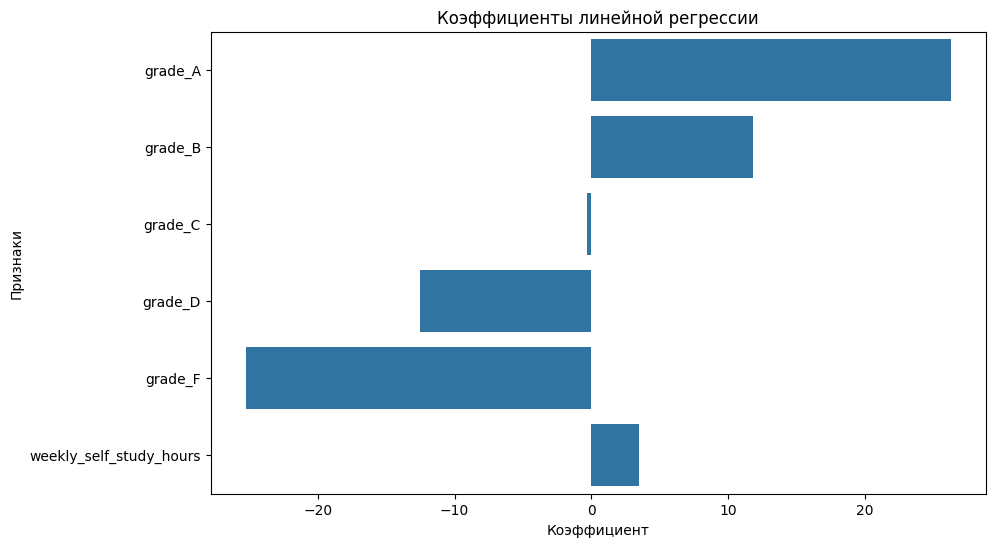

In [48]:
plt.figure(figsize=(10,6))
sns.barplot(x=model4.coef_, y=X_best.columns, orient="h")
plt.xlabel("Коэффициент")
plt.ylabel("Признаки")
plt.title("Коэффициенты линейной регрессии")
plt.show()

Данные демонстрируют стабильность и предсказуемость: все четыре модели показывают практически идентичные метрики и коэффициенты независимо от выбора признаков или разделения на выборки. Это свидетельствует о четких линейных зависимостях и отсутствии переобучения. Модель надежна и ее результатам можно доверять.